In [1]:
%load_ext autoreload

In [3]:
import os
import json
import cv2
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle
#sns.set(style='darkgrid')
sns.set(style='darkgrid', context='notebook',font_scale=1.5)

In [ ]:
%autoreload
import sys
sys.path.insert(0,'../')
from scripts.loader import *
import mytools as tl

# Datos

In [4]:
data_path = os.path.join('..', 'Datasets', 'Interiors')
resp_path = os.path.join(data_path, 'responses')
subj_path = os.path.join(data_path, 'human_scanpaths')
figs_path = os.path.join(os.getcwd(), 'figs')
resp_path

'../Datasets/Interiors/responses'

In [5]:
trials_data    = load_trials_properties(os.path.join(subj_path,'..', 'trials_properties.json'))
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'), human_subject='all')
responses_data = tl.get_responses_features(subjs_response)
responses_data.head()

subj                              img  max_fixations  scanpath_length  \
0    41      grayscale_11_opensource.jpg             13               10   
1    41  grayscale_18_housebeautiful.jpg              9               10   
2    41          grayscale_100_oliva.jpg              5                3   
3    41           grayscale_17_oliva.jpg              3                2   
4    41  grayscale_16_housebeautiful.jpg              3                4   

   target_found  target_found_response  response_size  \
0         False                  False             29   
1         False                  False             47   
2          True                  False             19   
3         False                  False             35   
4         False                  False             19   

   distance_response_to_target  distance_to_last_fix  delta_time_response  \
0                   266.810794            213.164661            49.599536   
1                   329.200547            411.615026             9.666707   
2                   202.054448            204.544005             5.633140   
3                   297.692795            208.923431             4.266648   
4                   568.198029            223.650531             2.900187   

   response_x  response_y  target_bbox_x  target_bbox_y  \
0       486.0       447.0            228            559   
1       520.0       538.0            797            400   
2       714.0       218.0            713            381   
3       433.0       316.0            186            490   
4       762.0       442.0            158            421   

   response_target_relative_x  response_target_relative_y  
0                      -258.0                       112.0  
1                       277.0                      -138.0  
2                        -1.0                       163.0  
3                      -247.0                       174.0  
4                      -604.0                       -21.0

# Performance acumulada

## A mano

<AxesSubplot:xlabel='max_fixations', ylabel='target_found'>

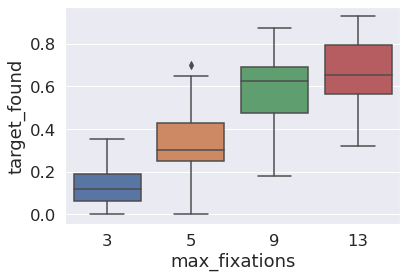

In [6]:
df=responses_data.groupby(['subj', 'max_fixations']).mean()['target_found']
sns.boxplot(data=df.reset_index(), x='max_fixations', y='target_found')

Using target found online


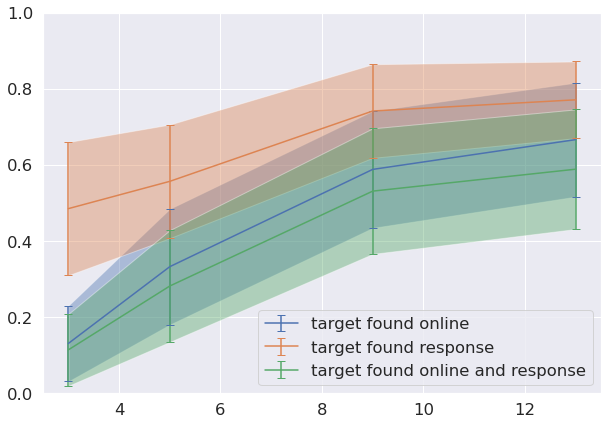

In [7]:
def cumulative_mean_performance_response(df, max_fix_key ='max_fixations', use_response=True):
    
    print('Using target found online')
    so = df.groupby(['subj', max_fix_key])['target_found'].sum()
    co = df.groupby(['subj', max_fix_key])['target_found'].count()
    perf_o = (so/co).groupby(['max_fixations']).agg(['mean', 'std'])
    
    if use_response:
        sr = df.groupby(['subj', max_fix_key])['target_found_response'].sum()
        cr = df.groupby(['subj', max_fix_key])['target_found_response'].count()
        perf_r = (sr/cr).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_r, lsuffix='_online', rsuffix='_response')
        df['target_found_online_response'] = df['target_found'] & df['target_found_response']
        so_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].sum()
        co_r = df.groupby(['subj', max_fix_key])['target_found_online_response'].count()
        perf_o_r = (so_r/co_r).groupby(['max_fixations']).agg(['mean', 'std'])
        # join with online target found
        perf_o = perf_o.join(perf_o_r)
        perf_o.rename(columns={'mean': 'mean_online_response', 'std': 'std_online_response'}, inplace=True)
        #perf_o.reset_index(inplace=True)
        
    return perf_o
 
aux  = cumulative_mean_performance_response(responses_data).reset_index()

_, ax = plt.subplots(1,1,figsize=(10,7))
ax.errorbar(aux['max_fixations'], aux['mean_online'], yerr = aux['std_online'], 
            label ='target found online', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_online']-aux['std_online'], 
                aux['mean_online']+aux['std_online'],
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_response'], yerr = aux['std_response'],
            label = 'target found response', capsize=4)
ax.fill_between(aux['max_fixations'], 
                aux['mean_response']-aux['std_response'], 
                aux['mean_response']+aux['std_response'], 
                alpha=0.4)

ax.errorbar(aux['max_fixations'], aux['mean_online_response'], yerr = aux['std_online_response'],
            label = 'target found online and response', capsize=4)
ax.fill_between(aux['max_fixations'],
                aux['mean_online_response']-aux['std_online_response'], 
                aux['mean_online_response']+aux['std_online_response'], alpha=0.4)

ax.set_ylim(0,1)
ax.legend()

plt.savefig(os.path.join(figs_path, f'lineplot_performance_responses.png'))

In [8]:
responses_data.scanpath_length.value_counts()

4     1433
3     1172
5     1017
6      783
2      482
8      467
7      464
9      421
10     313
12     228
13     213
11     179
14     141
Name: scanpath_length, dtype: int64

## Usando las funciones del repo

No handles with labels found to put in legend.


[Cumulative performance] Computing human mean for Interiors dataset


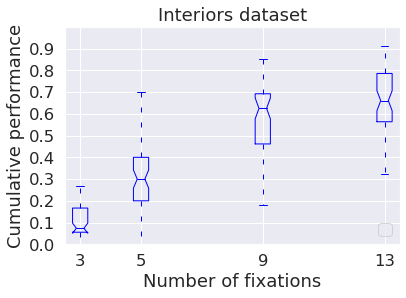

In [9]:
%autoreload
from Metrics.scripts.cumulative_performance import CumulativePerformance
perf = CumulativePerformance(dataset_name='Interiors', number_of_images=134, max_scanpath_length=15, compute=True)
#perf.compute_cumulative_performance(subjs_response[42])
perf.add_human_mean(humans_scanpaths_dir=os.path.join(resp_path, 'human_scanpaths'), humans_color='blue')
#perf.add_human_mean(humans_scanpaths_dir=subj_path, humans_color='blue')
perf.plot(save_path=figs_path)

# Performance: scanpath + respuesta

In [10]:
results_path = '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions'

In [11]:
def load_results_responses(res_path = '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions/'):
    """
    Function to load the results of the Interiors Responses dataset. 
    Recorre el path dado buscando los archivos que continen los resultados de las metricas fijacion a fijacion con el formato dado por el script de nnIBS.
    Los archivos son de la forma: 'subject_XX_results_fixations.json'
    Cada uno de estos archivos contiene el valor de la metrica correspondiente para esa sacada forzando el modelo a seguir al sujeto. 
    Carga los resultados en dos dataframes y devuelve dos listas con los errores encontrados.

    Args:
        res_path (str, optional): Path to the dataset. Defaults to '../Results/Interiors_Responses_dataset/nnIBS/subjects_predictions/'.

    Returns:
        dout1 (pd.DataFrame): Devuelve un dataframe con las medidas resumen de las metricas, con y sin la ultima fijacion(respuesta) 
                                y solo de las ultimas dos sacadas (descontando la respuesta).
        dout2 (pd.DataFrame): _description_
        missing (list): _description_
        onefix (list): _description_
    """
    dout = []
    dout2 = []
    missing = []
    onefix = []
    for subj_file in sorted([file for file in os.listdir(res_path) if 'fixations' in file]):
        with open(os.path.join(res_path, subj_file)) as json_file:
            d = json.load(json_file)
            for img in d.keys():
                for metric in d[img].keys():
                    val   = list(d[img][metric].values())
                    # number of saccades + 1 (response) = number of fixations (
                    n_fix = len(val)
                    # 'mean_response'
                    avg_r = np.mean(val)
                    # 'mean_no_response'
                    avg_nr = np.mean(val[:-1])
                    # 'mean_last_two'
                    avg_last_fix = np.mean(val[-3:-1])
                    # log erros: length 0, nans or one fix
                    if len(list(val))==0:
                        missing.append((subj_file, img, metric, 'length 0'))
                    elif np.nan in val:
                        missing.append((subj_file, img, metric, 'nans'))
                    elif len(val) ==1:
                        onefix.append((subj_file, img, metric, 'one fix'))    
                    dout.append({'subj':int(subj_file[8:10]), 'img':img , 'metric':metric, 'n_fix':n_fix,
                                 'response':val[-1], 'mean_response': avg_r, 'mean_no_response':avg_nr, 'mean_last_two':avg_last_fix})
                    for i,f in enumerate(val):
                        if i==len(val)-1:
                            nsacc = 'response'
                        elif i==len(val)-2:
                            nsacc = 'last'
                        else:
                            nsacc = i
                        dout2.append({'subj':int(subj_file[8:10]), 'img':img , 'metric':metric, 'n_fix':n_fix,
                                 'val':val[i], 'nsacc': nsacc, 'mean_response': avg_r, 'mean_no_response':avg_nr, 'mean_last_two':avg_last_fix})
                      
    return pd.DataFrame(dout), pd.DataFrame(dout2), missing, onefix

df_out, df_out_all, miss, onefix = load_results_responses(res_path=results_path)
print(f'Cantidad de datos con errores: {len(miss)}')
print(f'Cantidad de datos con una fijación: {len(onefix)}')

Cantidad de datos con errores: 0
Cantidad de datos con una fijación: 0


In [12]:
# No hay errores pero sin embargo hay NaNs
print(f'Cantidad de datos que no puede mirar la respuesta ni ultimas dos fijaciones: {df_out.mean_no_response.isna().sum()}')

Cantidad de datos que no puede mirar la respuesta ni ultimas dos fijaciones: 0


In [13]:
# Cargo ademas los tiempos de duración de las fijaciones - puedo mergear con alguno de los df_out
sdf = tl.create_scanpaths_df(subjs_response, use_response=True, calculate_distance=True).sort_values(by=['subj', 'img'])
sdf.head(10)

subj                              img fix_order      x      y     t  \
40850     1          grayscale_100_oliva.jpg         0  435.3  350.9  1653   
40851     1          grayscale_100_oliva.jpg         1  508.0  372.0   107   
40852     1          grayscale_100_oliva.jpg         2  752.0  410.8   144   
40853     1          grayscale_100_oliva.jpg         r  731.0  419.0     9   
41599     1  grayscale_10_housebeautiful.jpg         0  380.4  372.0  1816   
41600     1  grayscale_10_housebeautiful.jpg         1  432.7  490.9   180   
41601     1  grayscale_10_housebeautiful.jpg         2   73.3  537.9   176   
41602     1  grayscale_10_housebeautiful.jpg         r  132.0  497.0    31   
41438     1         grayscale_10_kitchen.jpg         0  796.8  370.3  1664   
41439     1         grayscale_10_kitchen.jpg         1  650.6  405.5   184   

       target_found  distance_to_target  
40850          True          320.588365  
40851          True          245.165250  
40852          True            6.887670  
40853          True           18.110770  
41599          True          364.284724  
41600          True          372.433752  
41601          True           19.516660  
41602          True           88.526832  
41438         False          186.030454  
41439         False          268.591158

In [14]:
# Veamos un sujeto y una imagen
df_out_all.query('subj==1 and img=="grayscale_100_oliva.jpg"')

subj                      img metric  n_fix       val     nsacc  \
2928     1  grayscale_100_oliva.jpg    AUC      3  0.908203         0   
2929     1  grayscale_100_oliva.jpg    AUC      3  0.995443      last   
2930     1  grayscale_100_oliva.jpg    AUC      3  0.995443  response   
2931     1  grayscale_100_oliva.jpg    NSS      3  1.548923         0   
2932     1  grayscale_100_oliva.jpg    NSS      3  6.074760      last   
2933     1  grayscale_100_oliva.jpg    NSS      3  8.739270  response   
2934     1  grayscale_100_oliva.jpg     IG      3 -4.007397         0   
2935     1  grayscale_100_oliva.jpg     IG      3  1.528849      last   
2936     1  grayscale_100_oliva.jpg     IG      3  0.120821  response   
2937     1  grayscale_100_oliva.jpg     LL      3  0.566395         0   
2938     1  grayscale_100_oliva.jpg     LL      3  1.466303      last   
2939     1  grayscale_100_oliva.jpg     LL      3  0.241720  response   

      mean_response  mean_no_response  mean_last_two  
2928       0.966363          0.951823       0.951823  
2929       0.966363          0.951823       0.951823  
2930       0.966363          0.951823       0.951823  
2931       5.454318          3.811842       3.811842  
2932       5.454318          3.811842       3.811842  
2933       5.454318          3.811842       3.811842  
2934      -0.785909         -1.239274      -1.239274  
2935      -0.785909         -1.239274      -1.239274  
2936      -0.785909         -1.239274      -1.239274  
2937       0.758139          1.016349       1.016349  
2938       0.758139          1.016349       1.016349  
2939       0.758139          1.016349       1.016349

In [15]:
df_out.shape, df_out_all.shape, len(onefix)

((29252, 8), (173384, 9), 0)

In [16]:
df_out.columns, df_out_all.columns

(Index(['subj', 'img', 'metric', 'n_fix', 'response', 'mean_response',
        'mean_no_response', 'mean_last_two'],
       dtype='object'),
 Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
        'mean_no_response', 'mean_last_two'],
       dtype='object'))

## Crear columna distancia a la fijación del último mapa


### Sanity check

In [17]:
# Comprobamos si nfix (que seria mas un nsac) que se lee del json coincide con la cantidad de csv guardados por sacada
aux1 = df_out_all[df_out_all.metric=='AUC'].groupby(['subj','img']).apply(len)
aux2 = (aux1 == df_out_all[df_out_all.metric=='AUC'].groupby(['subj','img']).apply(lambda x: x.iloc[0,:].n_fix))
aux2.sum() == aux2.shape[0]

True

### Mapas de sacadas y distancia al modelo

In [18]:
subjs_response = load_human_scanpaths(os.path.join(resp_path, 'human_scanpaths'), human_subject='all')
responses_data = tl.get_responses_features(subjs_response).set_index(['subj', 'img'])
responses_data.head()

max_fixations  scanpath_length  \
subj img                                                               
41   grayscale_11_opensource.jpg                 13               10   
     grayscale_18_housebeautiful.jpg              9               10   
     grayscale_100_oliva.jpg                      5                3   
     grayscale_17_oliva.jpg                       3                2   
     grayscale_16_housebeautiful.jpg              3                4   

                                      target_found  target_found_response  \
subj img                                                                    
41   grayscale_11_opensource.jpg             False                  False   
     grayscale_18_housebeautiful.jpg         False                  False   
     grayscale_100_oliva.jpg                  True                  False   
     grayscale_17_oliva.jpg                  False                  False   
     grayscale_16_housebeautiful.jpg         False                  False   

                                      response_size  \
subj img                                              
41   grayscale_11_opensource.jpg                 29   
     grayscale_18_housebeautiful.jpg             47   
     grayscale_100_oliva.jpg                     19   
     grayscale_17_oliva.jpg                      35   
     grayscale_16_housebeautiful.jpg             19   

                                      distance_response_to_target  \
subj img                                                            
41   grayscale_11_opensource.jpg                       266.810794   
     grayscale_18_housebeautiful.jpg                   329.200547   
     grayscale_100_oliva.jpg                           202.054448   
     grayscale_17_oliva.jpg                            297.692795   
     grayscale_16_housebeautiful.jpg                   568.198029   

                                      distance_to_last_fix  \
subj img                                                     
41   grayscale_11_opensource.jpg                213.164661   
     grayscale_18_housebeautiful.jpg            411.615026   
     grayscale_100_oliva.jpg                    204.544005   
     grayscale_17_oliva.jpg                     208.923431   
     grayscale_16_housebeautiful.jpg            223.650531   

                                      delta_time_response  response_x  \
subj img                                                                
41   grayscale_11_opensource.jpg                49.599536       486.0   
     grayscale_18_housebeautiful.jpg             9.666707       520.0   
     grayscale_100_oliva.jpg                     5.633140       714.0   
     grayscale_17_oliva.jpg                      4.266648       433.0   
     grayscale_16_housebeautiful.jpg             2.900187       762.0   

                                      response_y  target_bbox_x  \
subj img                                                          
41   grayscale_11_opensource.jpg           447.0            228   
     grayscale_18_housebeautiful.jpg       538.0            797   
     grayscale_100_oliva.jpg               218.0            713   
     grayscale_17_oliva.jpg                316.0            186   
     grayscale_16_housebeautiful.jpg       442.0            158   

                                      target_bbox_y  \
subj img                                              
41   grayscale_11_opensource.jpg                559   
     grayscale_18_housebeautiful.jpg            400   
     grayscale_100_oliva.jpg                    381   
     grayscale_17_oliva.jpg                     490   
     grayscale_16_housebeautiful.jpg            421   

                                      response_target_relative_x  \
subj img                                                           
41   grayscale_11_opensource.jpg                          -258.0   
     grayscale_18_housebeautiful.jpg                       277.0   
     grayscale_100_oliva.jpg                    

### Crear data frame con metricas de los modelos vs sujetos

El `df_all` tiene todas las metricas extra para la última fijación y la respuesta.

In [19]:
# esta celda tarda unos 12 minutos
df_all = tl.create_scanpaths_df_metrics_models(df_out_all, responses_data=responses_data, results_path=results_path)

Adding metrics for models...
Merging with responses data...
Adding category of trials...


In [20]:
df_all.shape, df_all.columns

((58504, 31),
 Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
        'mean_no_response', 'mean_last_two', 'subj_model_distance', 'nss_subj',
        'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
        'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_response_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'target_bbox_x', 'target_bbox_y',
        'response_target_relative_x', 'response_target_relative_y',
        'found_category'],
       dtype='object'))

In [21]:
df_out_all.columns

Index(['subj', 'img', 'metric', 'n_fix', 'val', 'nsacc', 'mean_response',
       'mean_no_response', 'mean_last_two'],
      dtype='object')

### Merge con el resto de las fijaciones/sacadas

In [22]:
# Saco val y n_fix de las columnas que me interesan porque 
my_cols = ['subj', 'img', 'metric', 'nsacc','subj_model_distance', 'nss_subj',
           'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
           'max_fixations', 'scanpath_length', 'target_found',
           'target_found_response', 'response_size', 'distance_response_to_target',
           'distance_to_last_fix', 'delta_time_response', 'response_x',
           'response_y', 'found_category']
df_all_full = df_all[my_cols].merge(df_out_all, on=['subj','img','metric', 'nsacc'], how='outer').sort_values(by=['subj','img','metric', 'nsacc'])
df_all_full.sample(5)

subj                     img metric     nsacc  subj_model_distance  \
166399    54  grayscale_54_oliva.jpg     LL         1                  NaN   
53361     53   grayscale_2_oliva.jpg    AUC  response            17.720045   
138352    41   grayscale_6_other.jpg     IG         8                  NaN   
139612    41  grayscale_56_oliva.jpg     IG         0                  NaN   
44211     44  grayscale_11_oliva.jpg    NSS  response             1.000000   

        nss_subj  nss_model   map_min   map_max  map_mean  ...  \
166399       NaN        NaN       NaN       NaN       NaN  ...   
53361   0.295131   5.112170  0.007774  0.039987  0.011791  ...   
138352       NaN        NaN       NaN       NaN       NaN  ...   
139612       NaN        NaN       NaN       NaN       NaN  ...   
44211   0.672502   1.162316  0.419320  0.458097  0.455080  ...   

        distance_to_last_fix  delta_time_response  response_x response_y  \
166399                   NaN                  NaN         NaN        NaN   
53361              52.939588             1.406068       976.0      357.0   
138352                   NaN                  NaN         NaN        NaN   
139612                   NaN                  NaN         NaN        NaN   
44211              80.389116             1.055442       704.0      279.0   

       found_category  n_fix       val  mean_response  mean_no_response  \
166399            NaN      4 -0.296641      -0.188459         -0.325890   
53361       TFO & TFR      5  0.802734       0.750391          0.737305   
138352            NaN     14  5.521447       0.489517          0.535342   
139612            NaN      6 -1.052910      -0.442071         -0.543121   
44211      ~TFO & TFR      7  0.672502       0.577374          0.561519   

        mean_last_two  
166399      -0.360759  
53361        0.583984  
138352       0.151879  
139612      -0.397851  
44211        0.616381  

[5 rows x 27 columns]

In [23]:
df_out_all

subj                             img metric  n_fix       val  \
0          1  grayscale_1_housebeautiful.jpg    AUC      8  0.797526   
1          1  grayscale_1_housebeautiful.jpg    AUC      8  0.956380   
2          1  grayscale_1_housebeautiful.jpg    AUC      8  0.854818   
3          1  grayscale_1_housebeautiful.jpg    AUC      8  0.707682   
4          1  grayscale_1_housebeautiful.jpg    AUC      8  0.860026   
...      ...                             ...    ...    ...       ...   
173379    57         grayscale_100_oliva.jpg    NSS      2  5.096384   
173380    57         grayscale_100_oliva.jpg     IG      2  1.617139   
173381    57         grayscale_100_oliva.jpg     IG      2 -0.227532   
173382    57         grayscale_100_oliva.jpg     LL      2  1.236733   
173383    57         grayscale_100_oliva.jpg     LL      2  0.297598   

           nsacc  mean_response  mean_no_response  mean_last_two  
0              0       0.888021          0.872675       0.966146  
1              1       0.888021          0.872675       0.966146  
2              2       0.888021          0.872675       0.966146  
3              3       0.888021          0.872675       0.966146  
4              4       0.888021          0.872675       0.966146  
...          ...            ...               ...            ...  
173379  response       4.736651          4.376917       4.376917  
173380      last       0.694803          1.617139       1.617139  
173381  response       0.694803          1.617139       1.617139  
173382      last       0.767166          1.236733       1.236733  
173383  response       0.767166          1.236733       1.236733  

[173384 rows x 9 columns]

In [24]:
# Como target found y response no estaban en el merge, los lleno con un backfill despues de ordenar
df_all_full[['target_found','target_found_response']] = df_all_full[['target_found','target_found_response']].fillna(method='bfill')

# Agrego la columna de categoriad de target
def cat_trial(row):
    if row['target_found'] and row['target_found_response']:
        return 'TFO & TFR'
    elif ~row['target_found'] and row['target_found_response']:
        return '~TFO & TFR'
    elif row['target_found'] and ~row['target_found_response']:
        return 'TFO & ~TFR'
    elif ~row['target_found'] and ~row['target_found_response']:
        return '~TFO & ~TFR'
    else:
        return 'ERROR'
print('Adding category of trials...')
responses_data_auxiliar_col = []
for _, row in df_all_full.iterrows():
    responses_data_auxiliar_col.append(cat_trial(row))
df_all_full['found_category'] = responses_data_auxiliar_col

Adding category of trials...


In [25]:
df_all_full.target_found_response

60384      True
1048       True
1049       True
60386      True
1052       True
          ...  
171819    False
171820    False
171821    False
57706     False
57707     False
Name: target_found_response, Length: 173384, dtype: bool

In [26]:
df_all_full.shape, df_all_full.columns

((173384, 27),
 Index(['subj', 'img', 'metric', 'nsacc', 'subj_model_distance', 'nss_subj',
        'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
        'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_response_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'found_category', 'n_fix', 'val', 'mean_response',
        'mean_no_response', 'mean_last_two'],
       dtype='object'))

In [27]:
df_all_full.isna().sum()

subj                                0
img                                 0
metric                              0
nsacc                               0
subj_model_distance            114880
nss_subj                       114880
nss_model                      114880
map_min                        114880
map_max                        114880
map_mean                       114880
map_std                        114880
max_fixations                  114880
scanpath_length                114880
target_found                        0
target_found_response               0
response_size                  114880
distance_response_to_target    114880
distance_to_last_fix           114880
delta_time_response            114880
response_x                     114880
response_y                     114880
found_category                      0
n_fix                               0
val                                 0
mean_response                       0
mean_no_response                    0
mean_last_tw

In [28]:
df_all_full.sort_values(by=['subj', 'img', 'metric','nsacc','target_found'])[['subj', 'img', 'metric','val','nsacc','subj_model_distance', 'nss_subj',
                                                               'target_found','target_found_response','found_category']].tail(20)

subj                    img metric       val     nsacc  \
171839    57  grayscale_9_other.jpg     LL  0.537233         6   
171840    57  grayscale_9_other.jpg     LL -0.011450         7   
171841    57  grayscale_9_other.jpg     LL  0.496991         8   
171842    57  grayscale_9_other.jpg     LL -0.185351         9   
171843    57  grayscale_9_other.jpg     LL -0.138160        10   
57710     57  grayscale_9_other.jpg     LL  0.085609      last   
57711     57  grayscale_9_other.jpg     LL  0.332551  response   
171811    57  grayscale_9_other.jpg    NSS  0.118259         0   
171812    57  grayscale_9_other.jpg    NSS  0.000000         1   
171813    57  grayscale_9_other.jpg    NSS  0.000000         2   
171814    57  grayscale_9_other.jpg    NSS  0.000000         3   
171815    57  grayscale_9_other.jpg    NSS  0.000000         4   
171816    57  grayscale_9_other.jpg    NSS  0.025385         5   
171817    57  grayscale_9_other.jpg    NSS  0.865857         6   
171818    57  grayscale_9_other.jpg    NSS  0.000000         7   
171819    57  grayscale_9_other.jpg    NSS  1.200827         8   
171820    57  grayscale_9_other.jpg    NSS  0.000000         9   
171821    57  grayscale_9_other.jpg    NSS  0.000000        10   
57706     57  grayscale_9_other.jpg    NSS  0.406717      last   
57707     57  grayscale_9_other.jpg    NSS  2.352092  response   

        subj_model_distance  nss_subj  target_found  target_found_response  \
171839                  NaN       NaN         False                  False   
171840                  NaN       NaN         False                  False   
171841                  NaN       NaN         False                  False   
171842                  NaN       NaN         False                  False   
171843                  NaN       NaN         False                  False   
57710              3.162278  1.836375         False                  False   
57711              5.830952  1.971935         False                  False   
171811                  NaN       NaN         False                  False   
171812                  NaN       NaN         False                  False   
171813                  NaN       NaN         False                  False   
171814                  NaN       NaN         False                  False   
171815                  NaN       NaN         False                  False   
171816                  NaN       NaN         False                  False   
171817                  NaN       NaN         False                  False   
171818                  NaN       NaN         False                  False   
171819                  NaN       NaN         False                  False   
171820                  NaN       NaN         False                  False   
171821                  NaN       NaN         False                  False   
57706              3.162278  1.836375         False                  False   
57707              5.830952  1.971935         False                  False   

       found_category  
171839    ~TFO & ~TFR  
171840    ~TFO & ~TFR  
171841    ~TFO & ~TFR  
171842    ~TFO & ~TFR  
171843    ~TFO & ~TFR  
57710     ~TFO & ~TFR  
57711     ~TFO & ~TFR  
171811    ~TFO & ~TFR  
171812    ~TFO & ~TFR  
171813    ~TFO & ~TFR  
171814    ~TFO & ~TFR  
171815    ~TFO & ~TFR  
171816    ~TFO & ~TFR  
171817    ~TFO & ~TFR  
171818    ~TFO & ~TFR  
171819    ~TFO & ~TFR  
171820    ~TFO & ~TFR  
171821    ~TFO & ~TFR  
57706     ~TFO & ~TFR  
57707     ~TFO & ~TFR

### Save and load

In [29]:
# por las dudas lo guardamos en cache para ahorrarnos los 15 min previos
# df_all_full.to_csv('./cache/df_con_distancias_2022.csv')
# df_all_full = pd.read_csv('./cache/df_con_distancias_2022.csv', header=0, index_col=0)

# Comparación de rendimiento medio

Hasta aca tengo dos dataframes principales, uno agregado y uno sin agregar y con mas informacion:
- df_out: tiene la informacion agregada, rendimiento medio para el par (subj, img) con columnas `['metric', 'n_fix', 'response', 'mean_response',
       'mean_no_response', 'mean_last_two']`
- df_all: tiene la informacion desagregada, incluyendo la metrica de distancia euclidea () entre la proxima ubicacion para el modelo y para el sujeto, columnas 
       `['nsacc', 'subj_model_distance', 'max_fixations', 'scanpath_length', 'target_found',
        'target_found_response', 'response_size', 'distance_to_target',
        'distance_to_last_fix', 'delta_time_response', 'response_x',
        'response_y', 'n_fix', 'val', 'mean_response', 'mean_no_response',
        'mean_last_two', 'found_category']`

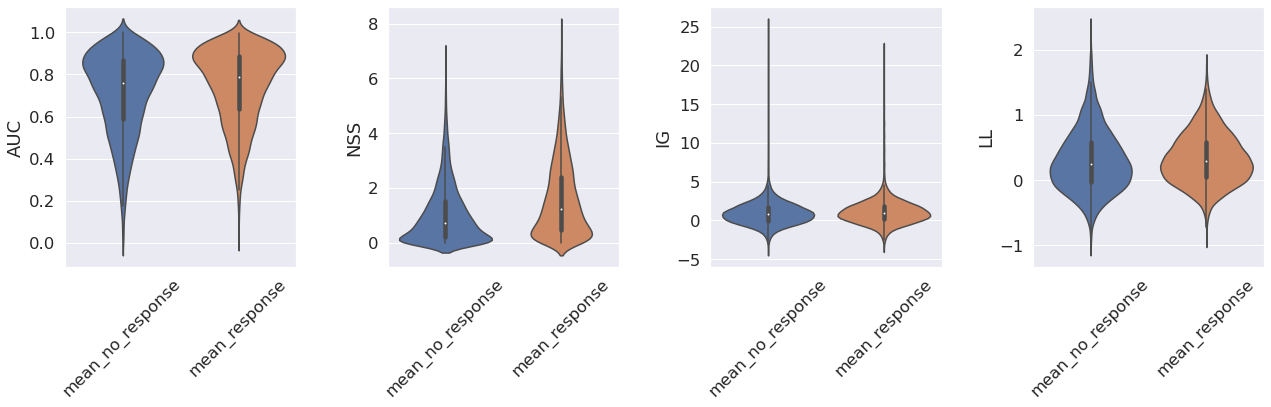

In [30]:
def compare_model_response_pred_metrics(df, cols_to_compare):
    _, axs = plt.subplots(1,4, figsize=(18,6))
    for ax, met in zip(axs.ravel(), df.metric.unique()):
        aux = df[df.metric==met][cols_to_compare]
        sns.violinplot(data=aux,ax=ax)
        ax.set_ylabel(met)
        ax.set_xticklabels(cols_to_compare, rotation=45) #ax.get_xticks()
    plt.tight_layout()

compare_model_response_pred_metrics(df_out, ['mean_no_response', 'mean_response'])

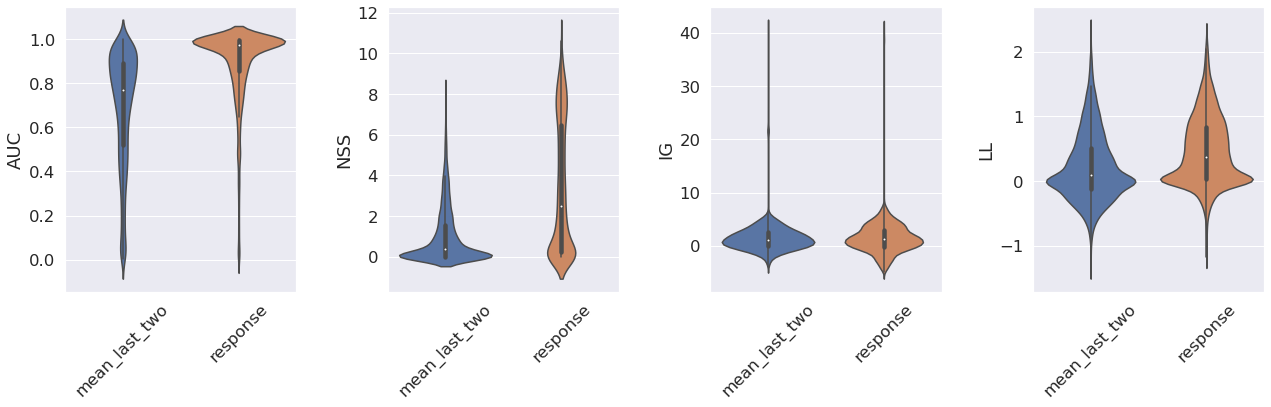

In [31]:
compare_model_response_pred_metrics(df_out, ['mean_last_two','response'])

## Comparación por tipo de trial

In [32]:
df_all.nsacc.value_counts() #metric, nsacc, found_category en este estan duplicados las respuestas

last        29252
response    29252
Name: nsacc, dtype: int64

/home/gastonb/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


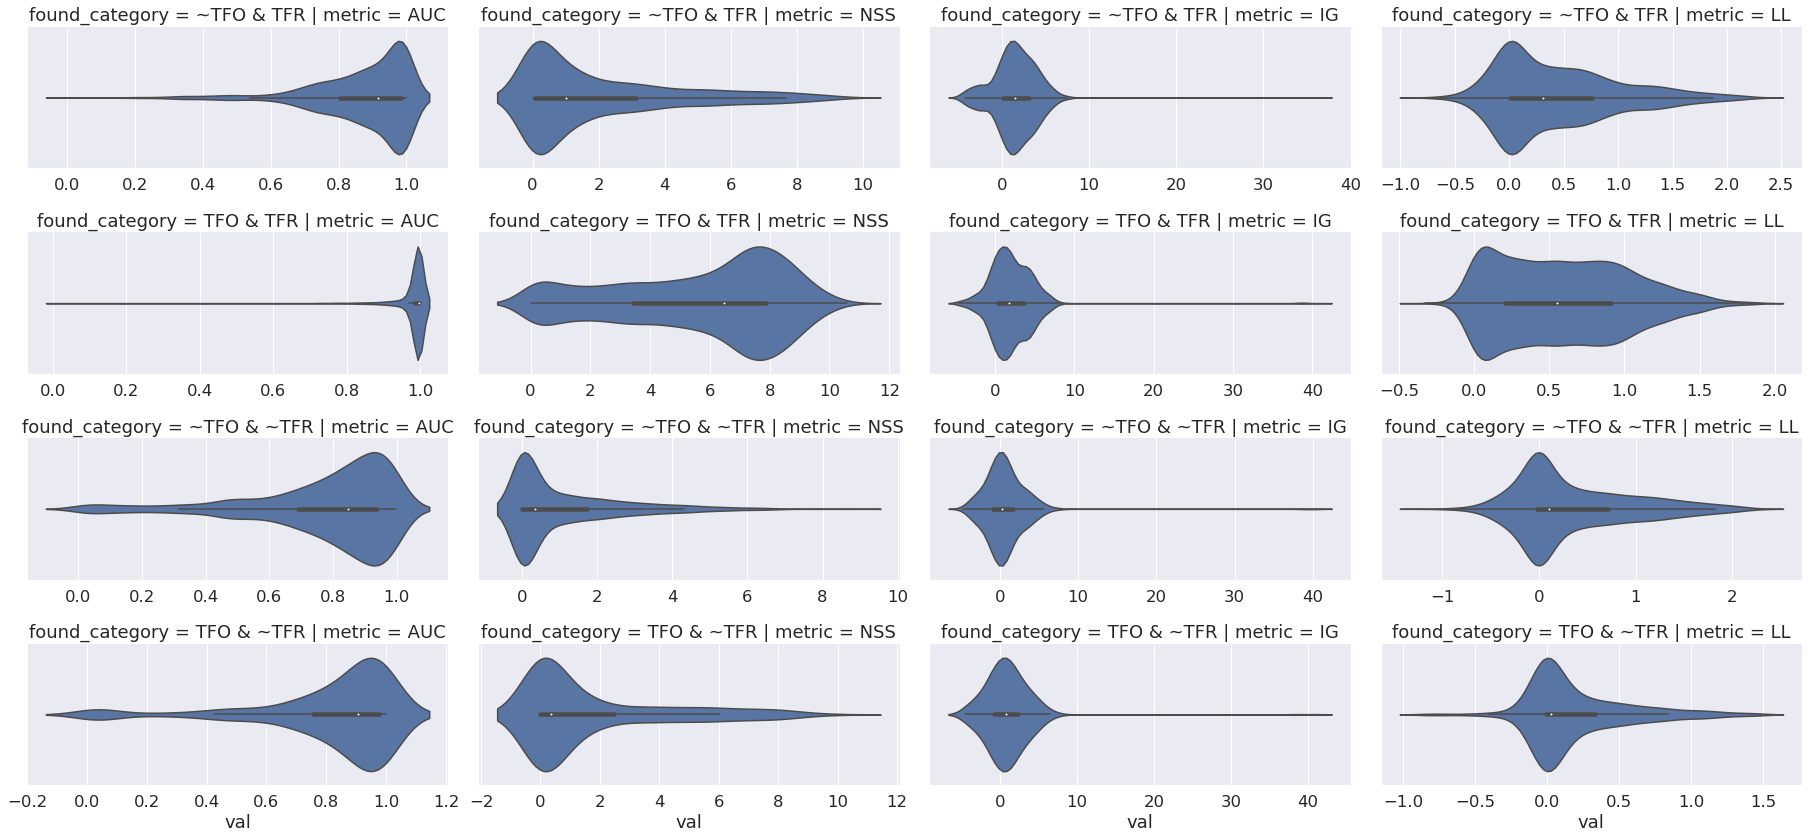

In [33]:
# Distribucion de las metricas para la respuesta para cada categoria de trial
grid = sns.FacetGrid(df_all.query('nsacc=="response"'), col='metric', row='found_category',
                    palette="GnBu_d", height=3, aspect=2.1, sharex=False)

bins_hist = np.linspace(-4,4,30)
grid.map(sns.violinplot, 'val', stat='percent', alpha=0.8, common_norm=False);

/home/gastonb/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


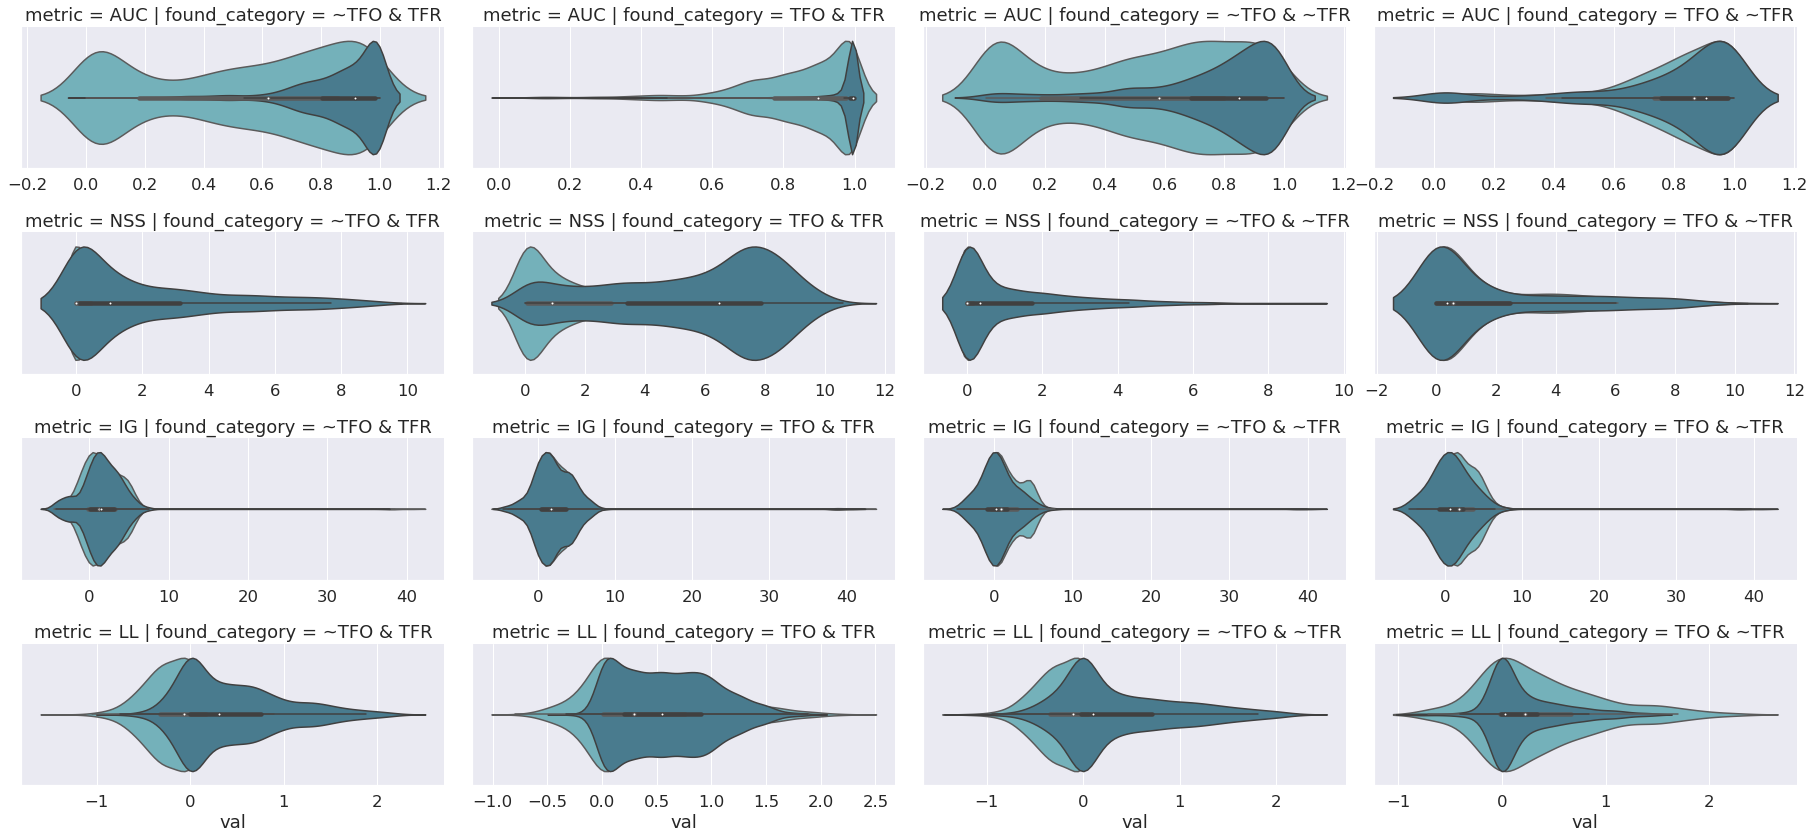

In [34]:
# Distribucion de las metricas para la última fijacion para cada categoria de trial
grid = sns.FacetGrid(df_all, row='metric', col='found_category',
                    palette="GnBu_d", height=3, aspect=2.1, sharex=False, hue='nsacc')

bins_hist = np.linspace(-4,4,30)
grid.map(sns.violinplot, 'val', stat='percent', alpha=0.6, common_norm=False)

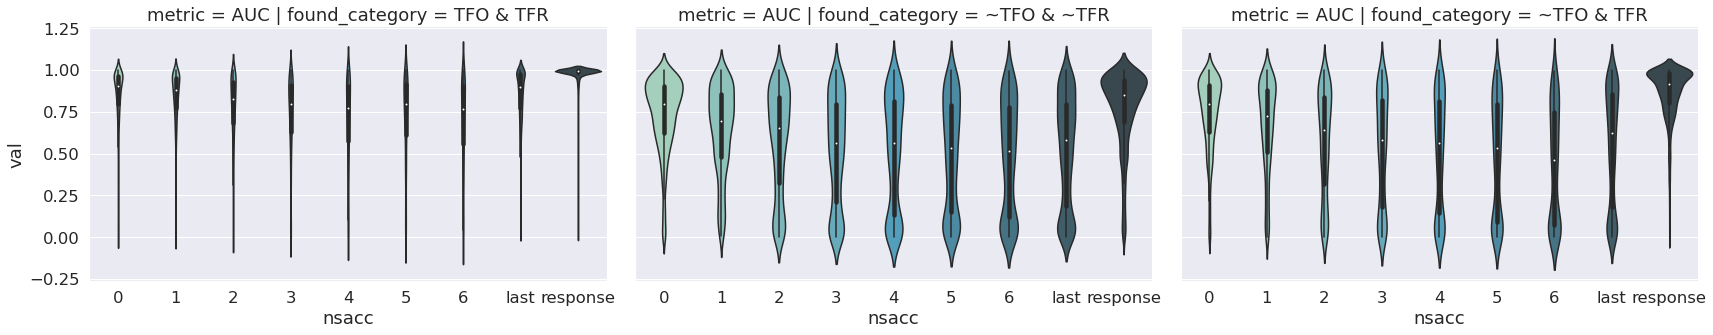

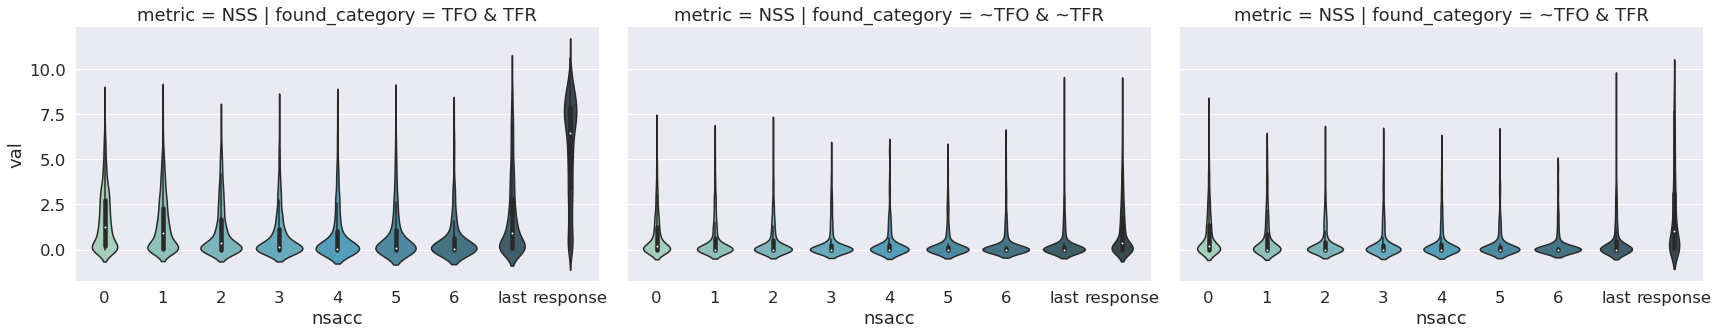

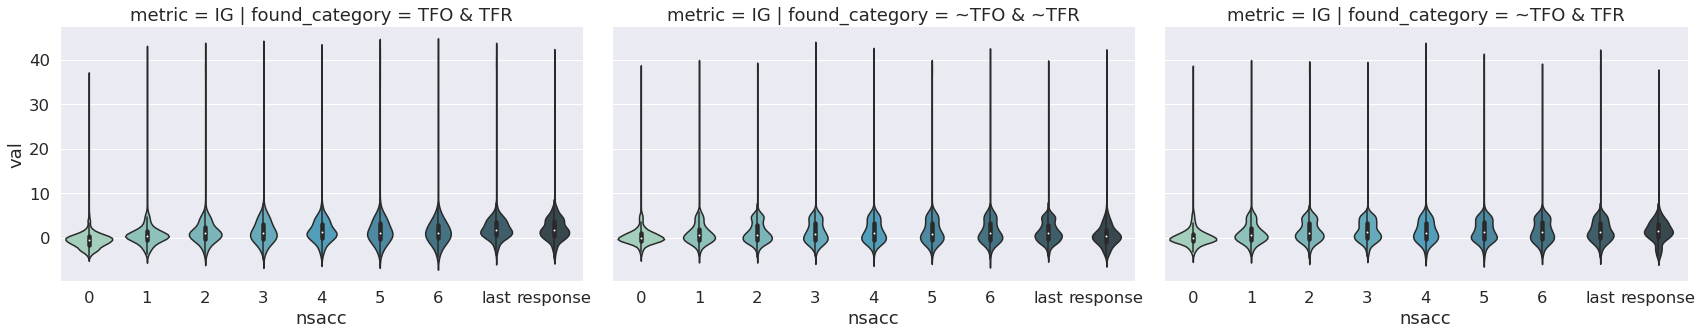

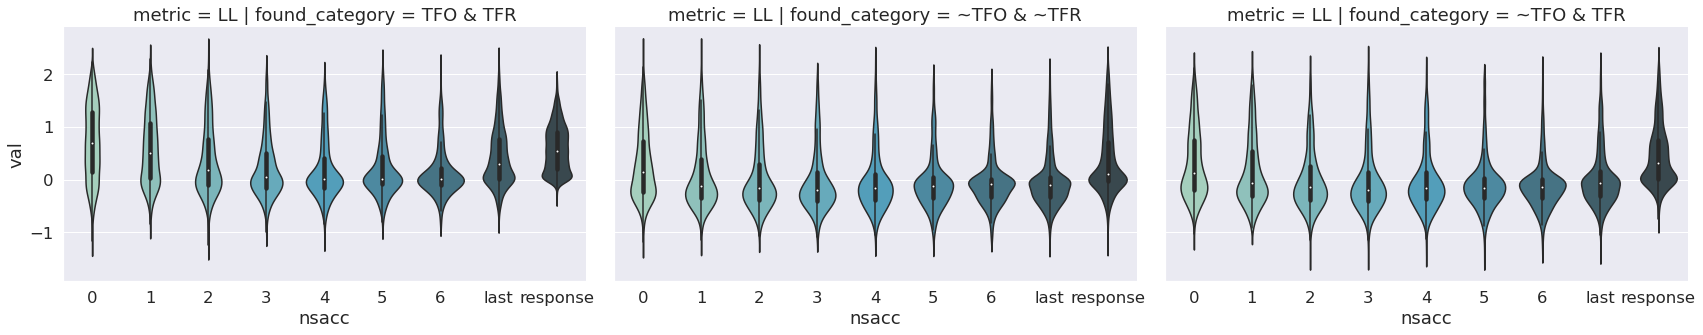

In [35]:
# Distribucion de los scores de las metricas para cada categoria de trial y cada orden de sacada
my_cols = ['metric', 'val', 'nsacc', 'found_category']
q = 'nsacc in ["response","last",0,1,2,3,4,5,6] and found_category!="TFO & ~TFR"' 
for qy in [q+f' and metric=="{m}"' for m in df_all.metric.unique()]:
    g = sns.catplot(data=df_all_full[my_cols].query(qy), x='nsacc', y='val', kind='violin', row='metric', col='found_category',
                    order =[0,1,2,3,4,5,6,"last","response"],
                    palette="GnBu_d", heigth=2, aspect=1.6, sharey=True, scale_hue=True)

# Analisis restantes

- Mirar el tiempo de fijación vs el response size? La idea seria ver si el tiempo de la fijación en el target correlaciona con el tamaño de la respuesta y la correctitud de la misma.
- 

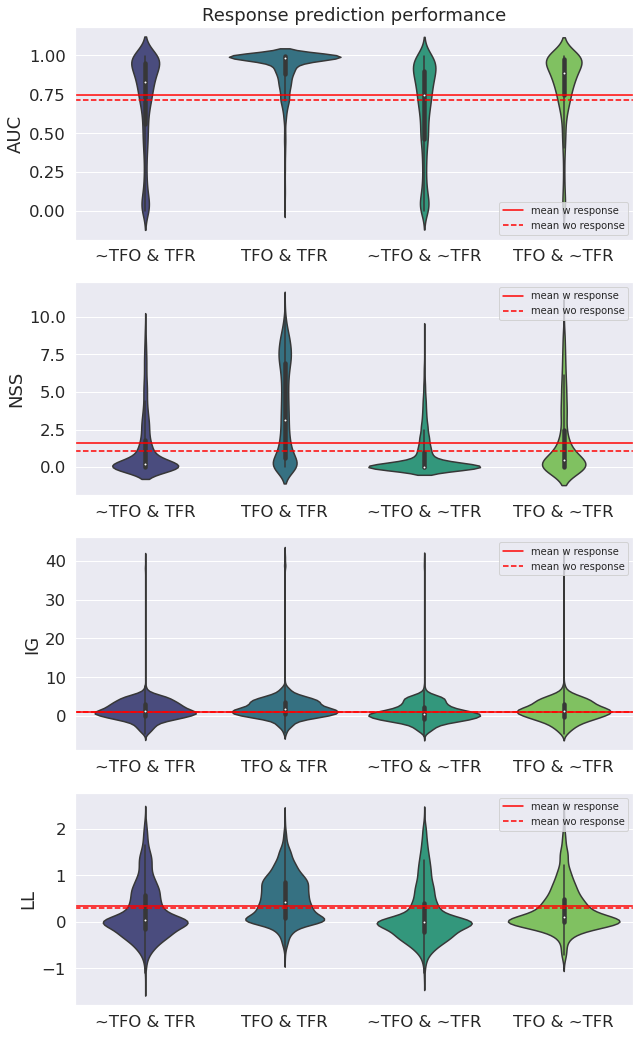

In [38]:
# AGREGAR EN CADA GRAFICO
# linea que sea la media del modelo para cada 

_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'val'
axs[0].set_title('Response prediction performance');
for ax, met in zip(axs.ravel(), df_all.metric.unique()):
    aux = df_all.query('metric==@met')
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category', data=aux, ax=ax, palette='viridis')
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean w response'))
    lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')

In [39]:
df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))].head(10)

subj                             img metric  n_fix       val     nsacc  \
6      1  grayscale_1_housebeautiful.jpg     LL      8  0.063124      last   
7      1  grayscale_1_housebeautiful.jpg     LL      8  0.002880  response   
14     1         grayscale_1_kitchen.jpg     LL      6  0.438859      last   
15     1         grayscale_1_kitchen.jpg     LL      6  0.589875  response   
22     1           grayscale_1_oliva.jpg     LL      5  0.617651      last   
23     1           grayscale_1_oliva.jpg     LL      5  1.278599  response   
30     1      grayscale_1_opensource.jpg     LL     10  0.000560      last   
31     1      grayscale_1_opensource.jpg     LL     10  0.000582  response   
38     1  grayscale_2_housebeautiful.jpg     LL      5  0.726507      last   
39     1  grayscale_2_housebeautiful.jpg     LL      5  0.393535  response   

    mean_response  mean_no_response  mean_last_two  subj_model_distance  ...  \
6        0.251722          0.287270       0.238036             1.000000  ...   
7        0.251722          0.287270       0.238036             1.414214  ...   
14       0.258111          0.191759       0.123111            16.124515  ...   
15       0.258111          0.191759       0.123111             0.000000  ...   
22       0.355577          0.124822       0.178579            13.000000  ...   
23       0.355577          0.124822       0.178579             1.000000  ...   
30       0.073026          0.081075       0.000523             8.602325  ...   
31       0.073026          0.081075       0.000523             4.242641  ...   
38       0.871460          0.990941       0.841702             1.000000  ...   
39       0.871460          0.990941       0.841702             1.000000  ...   

    distance_response_to_target  distance_to_last_fix  delta_time_response  \
6                     21.540659             78.365809             0.466865   
7                     21.540659             78.365809             0.466865   
14                    10.630146             59.573148             0.666899   
15                    10.630146             59.573148             0.666899   
22                    17.804494             38.296997             0.566944   
23                    17.804494             38.296997             0.566944   
30                   104.623133            416.445843             1.300026   
31                   104.623133            416.445843             1.300026   
38                    17.492856             41.154587             4.733354   
39                    17.492856             41.154587             4.733354   

    response_x  response_y  target_bbox_x  target_bbox_y  \
6        186.0       199.0            130            155   
7        186.0       199.0            130            155   
14       883.0       313.0            855            270   
15       883.0       313.0            855            270   
22       153.0       627.0            106            605   
23       153.0       627.0            106            605   
30       791.0       323.0            700            376   
31       791.0       323.0            700            376   
38       492.0       520.0            447            499   
39       492.0       520.0            447            499   

    response_target_relative_x  response_target_relative_y  found_category  
6                        -56.0                       -44.0      ~TFO & TFR  
7                        -56.0                       -44.0      ~TFO & TFR  
14                       -28.0                       -43.0       TFO & TFR  
15                       -28.0                       -43.0       TFO & TFR  
22                       -47.0                       -22.0       TFO & TFR  
23                       -47.0                       -22.0       TFO & TFR  
30                       -91.0                        53.0     ~TFO & ~TFR  
31                       -91.0                        53.0     ~TFO & ~TFR  
38                       -45.0                     

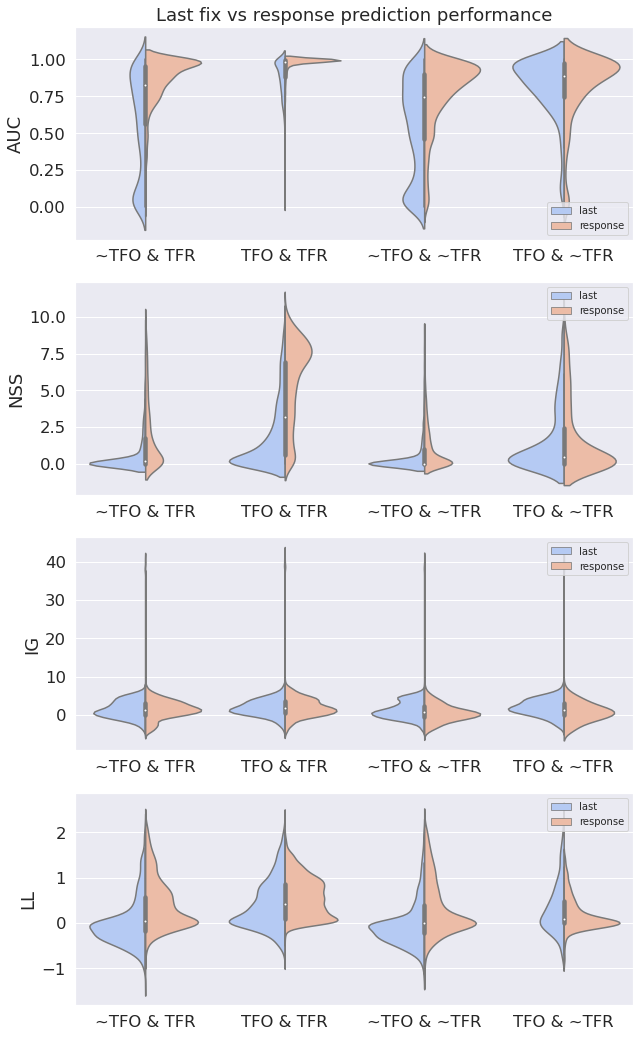

In [40]:
_, axs = plt.subplots(4,1, figsize=(10,18))
VAR = 'val'
axs[0].set_title('Last fix vs response prediction performance');
for ax, met in zip(axs.ravel(), df_all.metric.unique()):
    aux = df_all[(df_all.metric==met) & (df_all.nsacc.isin(['response','last']))]
    aux = aux[~aux.mean_no_response.isna()]
    #sns.histplot(x='response',hue='target_found', data=aux, ax=ax, stat='percent', common_norm=False)
    sns.violinplot(y=VAR, x='found_category',hue='nsacc',split=True, data=aux, ax=ax, palette='coolwarm')
    #sns.catplot(y=met, hue='target_found', data=aux, ax=ax)
    lines = []
    #lines.append(ax.axhline(aux.mean_response.mean(),color='red',ls='-', label='mean response'))
    #lines.append(ax.axhline(aux.mean_no_response.mean(),color='red',ls='--', label = 'mean wo response'))
    #leg = Legend(ax, lines, ['mean response', 'mean no response'], frameon=False, loc='center',fontsize=12)
    #ax.add_artist(leg)
    ax.legend(prop={'size': 10})
    ax.set_ylabel(met)
    ax.set_xlabel('')

## Distancia al modelo

In [41]:
df_not_repeated = df_all.query('nsacc in ["response","last"] and metric=="NSS" and found_category!="TFO & ~TFR"')

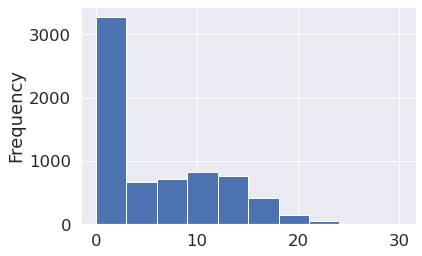

In [42]:
df_not_repeated[df_not_repeated.nsacc=='response']['subj_model_distance'].plot(kind='hist');

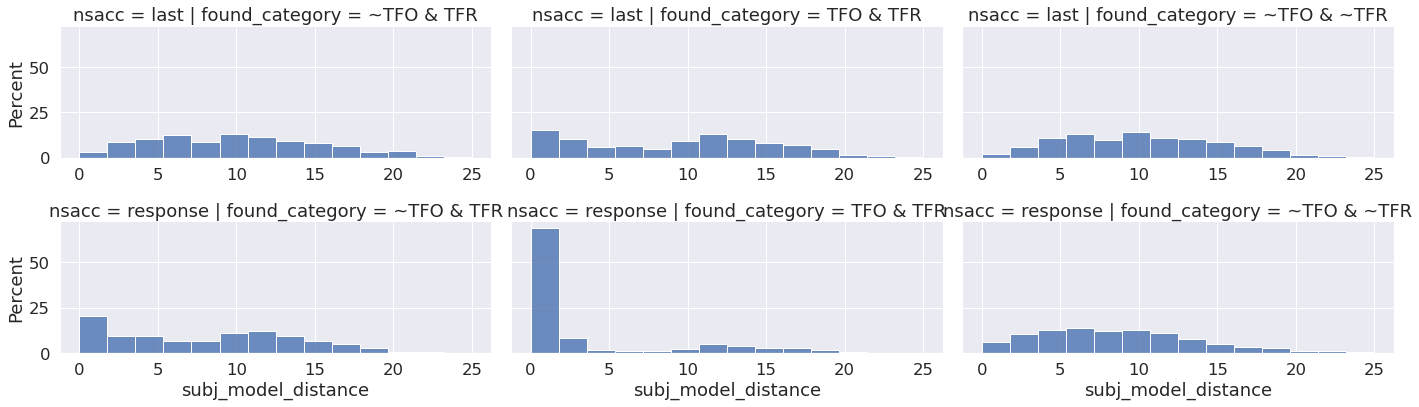

In [43]:
# Distribucion de las metricas para la respuesta para cada categoria de trial
g = sns.FacetGrid(df_not_repeated, row='nsacc', col='found_category',
                    palette="GnBu_d", height=3, aspect=2.2, sharex=False)

bins_hist = np.linspace(0,25,15)
g.map(sns.histplot, 'subj_model_distance', stat='percent', alpha=0.8, common_norm=False, bins=bins_hist);

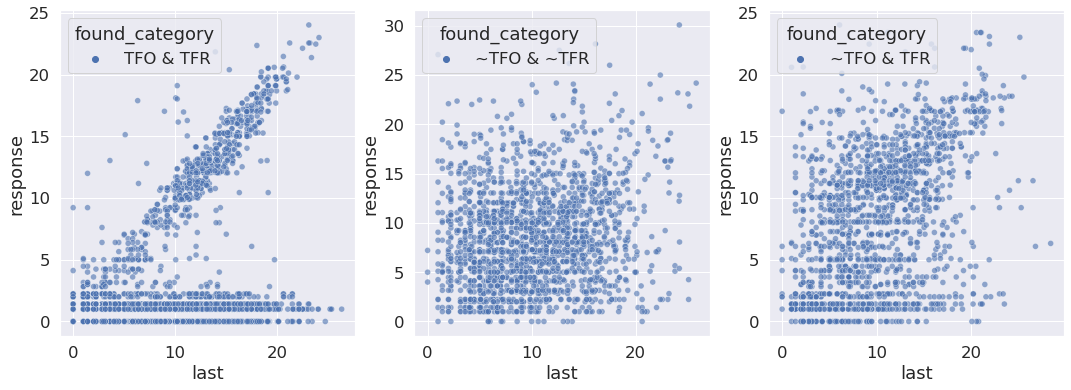

In [44]:
tabla_distancias = pd.pivot(df_not_repeated[['subj', 'img','nsacc', 'subj_model_distance','found_category']], 
                            index=['subj', 'img','found_category'], columns='nsacc', values='subj_model_distance').reset_index()
_, ax= plt.subplots(1,3, figsize=(18,6))
for ax_, cat in zip(ax, tabla_distancias.found_category.unique()):
    sns.scatterplot(data=tabla_distancias.query('found_category==@cat'), hue='found_category', x='last', y ='response', alpha=0.6, ax=ax_)

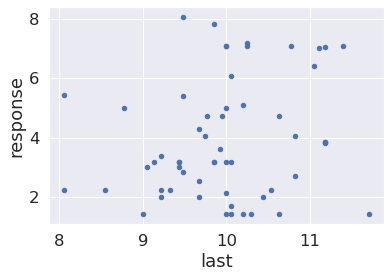

In [46]:
tabla_distancias.groupby(by='subj').median().plot(kind='scatter', x='last', y ='response',c='b')
plt.show()

In [47]:
tabla_distancias[['last', 'response']].corr()

nsacc         last  response
nsacc                       
last      1.000000  0.354946
response  0.354946  1.000000

In [127]:
df_not_repeated

subj                             img metric  n_fix       val     nsacc  \
2         1  grayscale_1_housebeautiful.jpg    NSS      8  5.124688      last   
3         1  grayscale_1_housebeautiful.jpg    NSS      8  0.351543  response   
10        1         grayscale_1_kitchen.jpg    NSS      6  0.811794      last   
11        1         grayscale_1_kitchen.jpg    NSS      6  9.522324  response   
18        1           grayscale_1_oliva.jpg    NSS      5  0.833679      last   
...     ...                             ...    ...    ...       ...       ...   
58475    57          grayscale_92_oliva.jpg    NSS      2  4.774669  response   
58482    57          grayscale_94_oliva.jpg    NSS      7  0.000000      last   
58483    57          grayscale_94_oliva.jpg    NSS      7  0.237569  response   
58490    57          grayscale_98_oliva.jpg    NSS     11  0.000000      last   
58491    57          grayscale_98_oliva.jpg    NSS     11  5.656636  response   

       mean_response  mean_no_response  mean_last_two  subj_model_distance  \
2           1.340039          1.481253       3.569346             1.000000   
3           1.340039          1.481253       3.569346             1.414214   
10          2.042686          0.546758       0.405897            16.124515   
11          2.042686          0.546758       0.405897             0.000000   
18          1.825393          0.317240       0.416840            13.000000   
...              ...               ...            ...                  ...   
58475       2.891645          1.008621       1.008621             2.236068   
58482       0.616449          0.679595       0.093816            13.000000   
58483       0.616449          0.679595       0.093816             6.708204   
58490       1.757844          1.367965       0.000000            19.104973   
58491       1.757844          1.367965       0.000000            18.027756   

       ...  distance_to_target  distance_to_last_fix  delta_time_response  \
2      ...           21.540659             78.365809             0.466865   
3      ...           21.540659             78.365809             0.466865   
10     ...           10.630146             59.573148             0.666899   
11     ...           10.630146             59.573148             0.666899   
18     ...           17.804494             38.296997             0.566944   
...    ...                 ...                   ...                  ...   
58475  ...          390.950125            188.753066             2.400178   
58482  ...          565.286653            616.198353             1.800052   
58483  ...          565.286653            616.198353             1.800052   
58490  ...           27.513633             49.211787             1.833416   
58491  ...           27.513633             49.211787             1.833416   

       response_x  response_y  target_bbox_x  target_bbox_y  \
2           186.0       199.0            130            155   
3           186.0       199.0            130            155   
10          883.0       313.0            855            270   
11          883.0       313.0            855            270   
18          153.0       627.0            106            605   
...           ...         ...            ...            ...   
58475       652.0       334.0            227            337   
58482       340.0       269.0            869            215   
58483       340.0       269.0            869            215   
58490       917.0       442.0            855            397   
58491       917.0       442.0            855            397   

       response_target_relative_x  response_target_relative_y  found_category  
2                           -56.0                       -44.0      ~TFO & TFR  
3                           -56.0                       -44.0      ~TFO & TFR  
10                          -28.0                       -43.0       TFO & TFR  
11                          -28.0                       -43.0       TFO & TFR  
18             

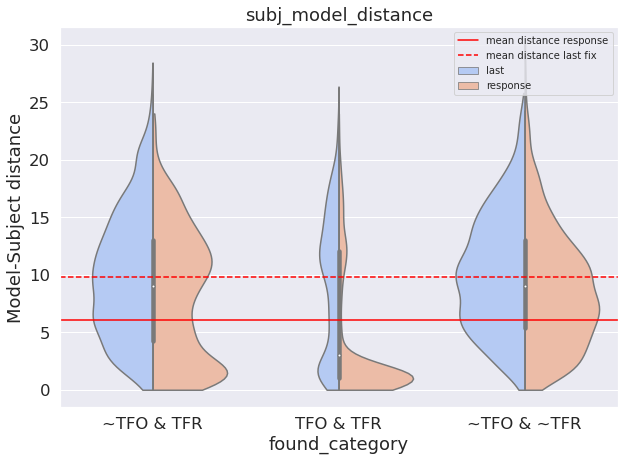

In [49]:
_, ax = plt.subplots(1,1, figsize=(10,7))
VAR = 'subj_model_distance'
ax.set_title(f'{VAR}');
aux = df_not_repeated[~df_not_repeated.mean_no_response.isna()]
sns.violinplot(y=VAR, x='found_category',hue='nsacc',split=True, data=aux, ax=ax, cut=0, palette='coolwarm')
mean_dist_response = aux[VAR][aux.nsacc=='response'].mean() 
mean_dist_last     = aux[VAR][aux.nsacc=='last'].mean()
ax.axhline(mean_dist_response,color='red',ls='-', label='mean distance response')
ax.axhline(mean_dist_last,color='red',ls='--', label='mean distance last fix')
ax.legend(prop={'size': 10});
ax.set_ylabel('Model-Subject distance');

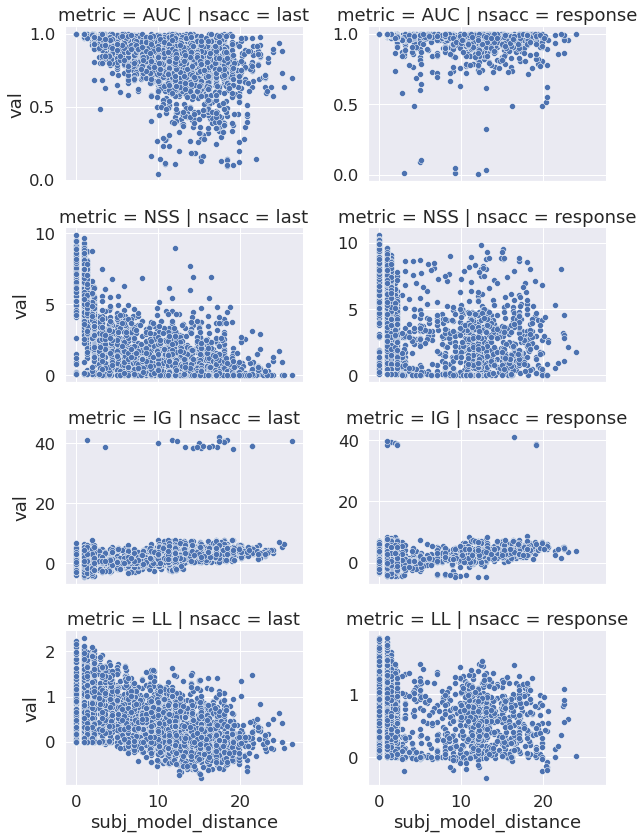

In [50]:
aux = df_all.query('found_category == "TFO & TFR"').query('nsacc == "last" or nsacc=="response"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, col='nsacc', row='metric', sharey=False, height=3, aspect=1.5)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

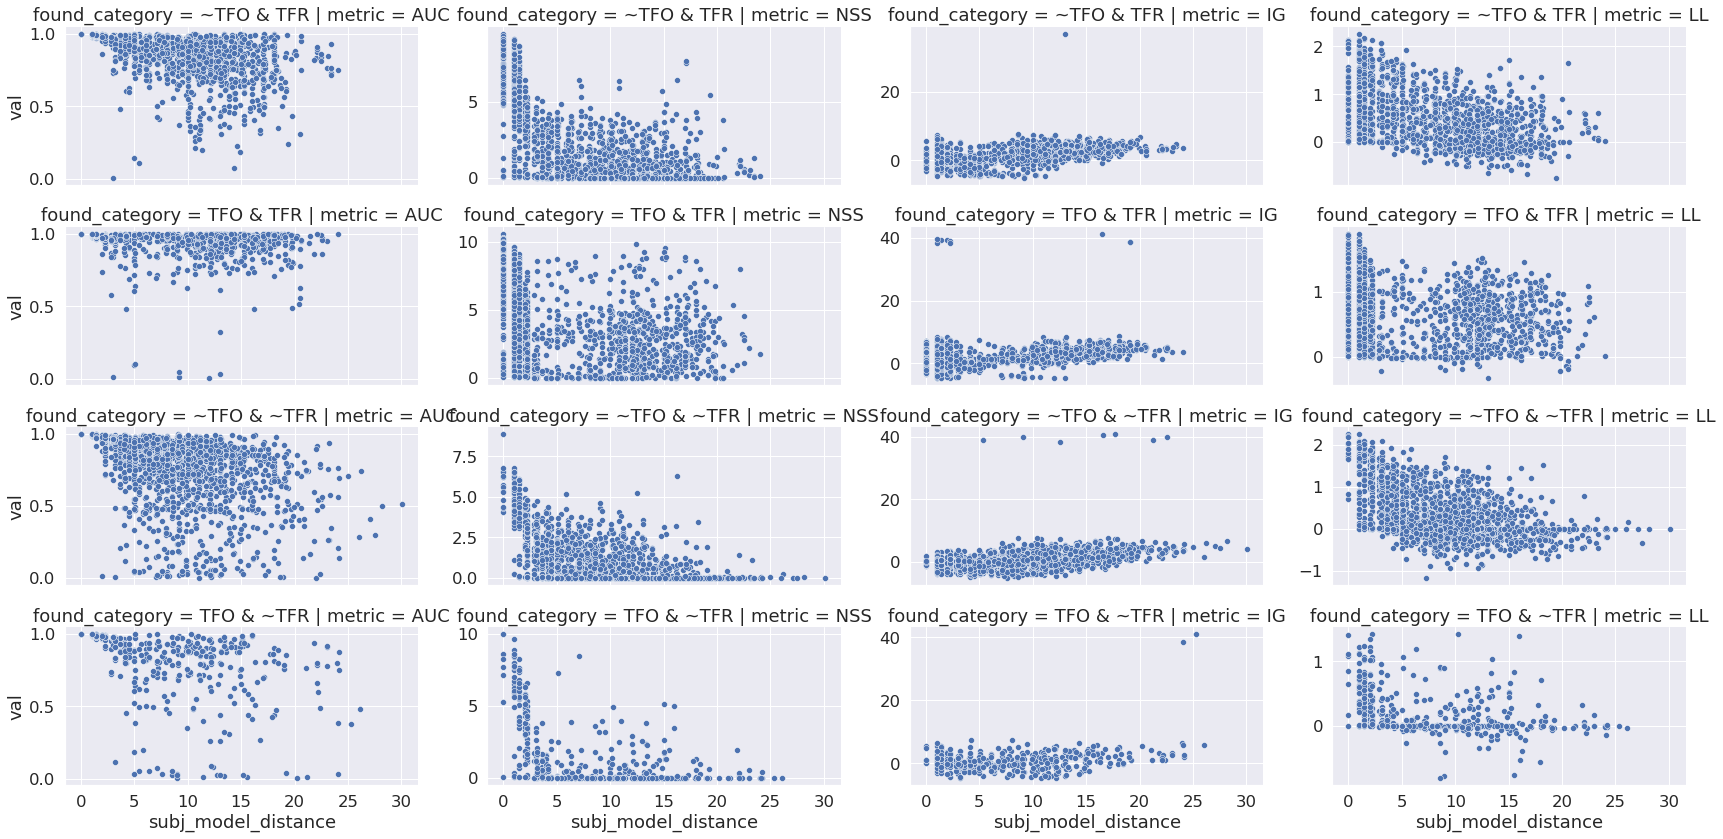

In [51]:
aux = df_all.query('nsacc=="response"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

Una cosa que podemos mirar es rendimiento por rango de fijaciones. Para cada rango de fijación tengo una distribución de scores (una distribución para cada métrica), la pregunta es si la distribución de las respuestas es distinta o no a la 

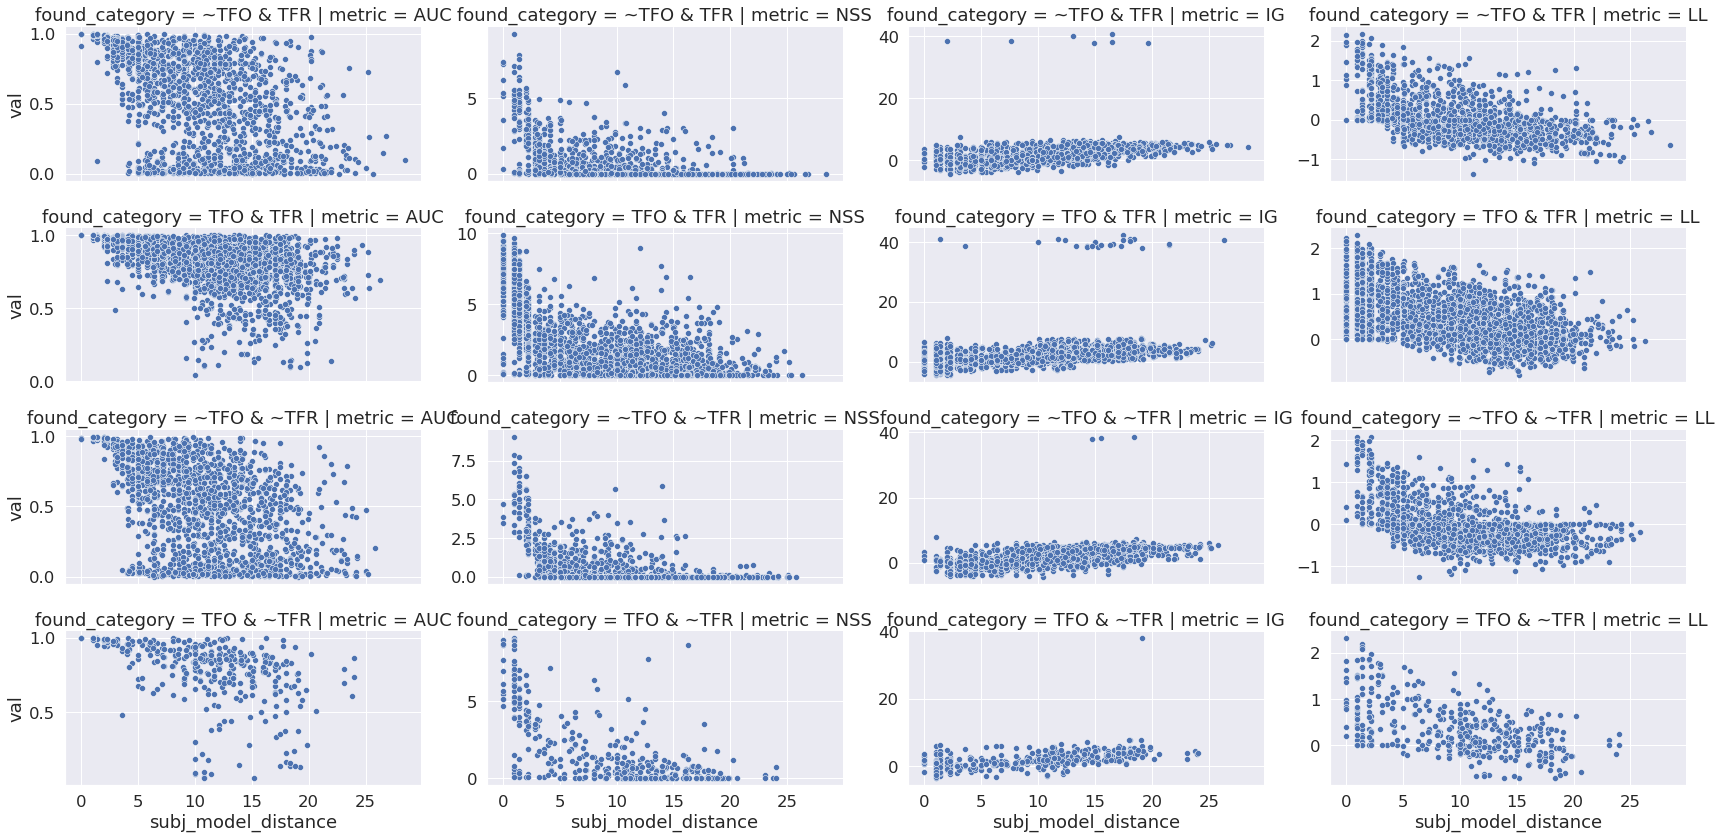

In [52]:
aux = df_all.query('nsacc=="last"')[['subj','img','nsacc','metric','val','subj_model_distance','found_category']]
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'subj_model_distance', 'val')

### Mirando respuesta, tamaño, NSS y tiempo

Terminar

In [53]:
aux = df_all.query('nsacc=="response"')[['subj','img','nsacc','metric','val', 'nss_subj',
                'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std','subj_model_distance','found_category', 'response_size']].copy()
aux['nss_diff'] = aux['nss_model'] - aux['nss_subj']
aux.columns

Index(['subj', 'img', 'nsacc', 'metric', 'val', 'nss_subj', 'nss_model',
       'map_min', 'map_max', 'map_mean', 'map_std', 'subj_model_distance',
       'found_category', 'response_size', 'nss_diff'],
      dtype='object')

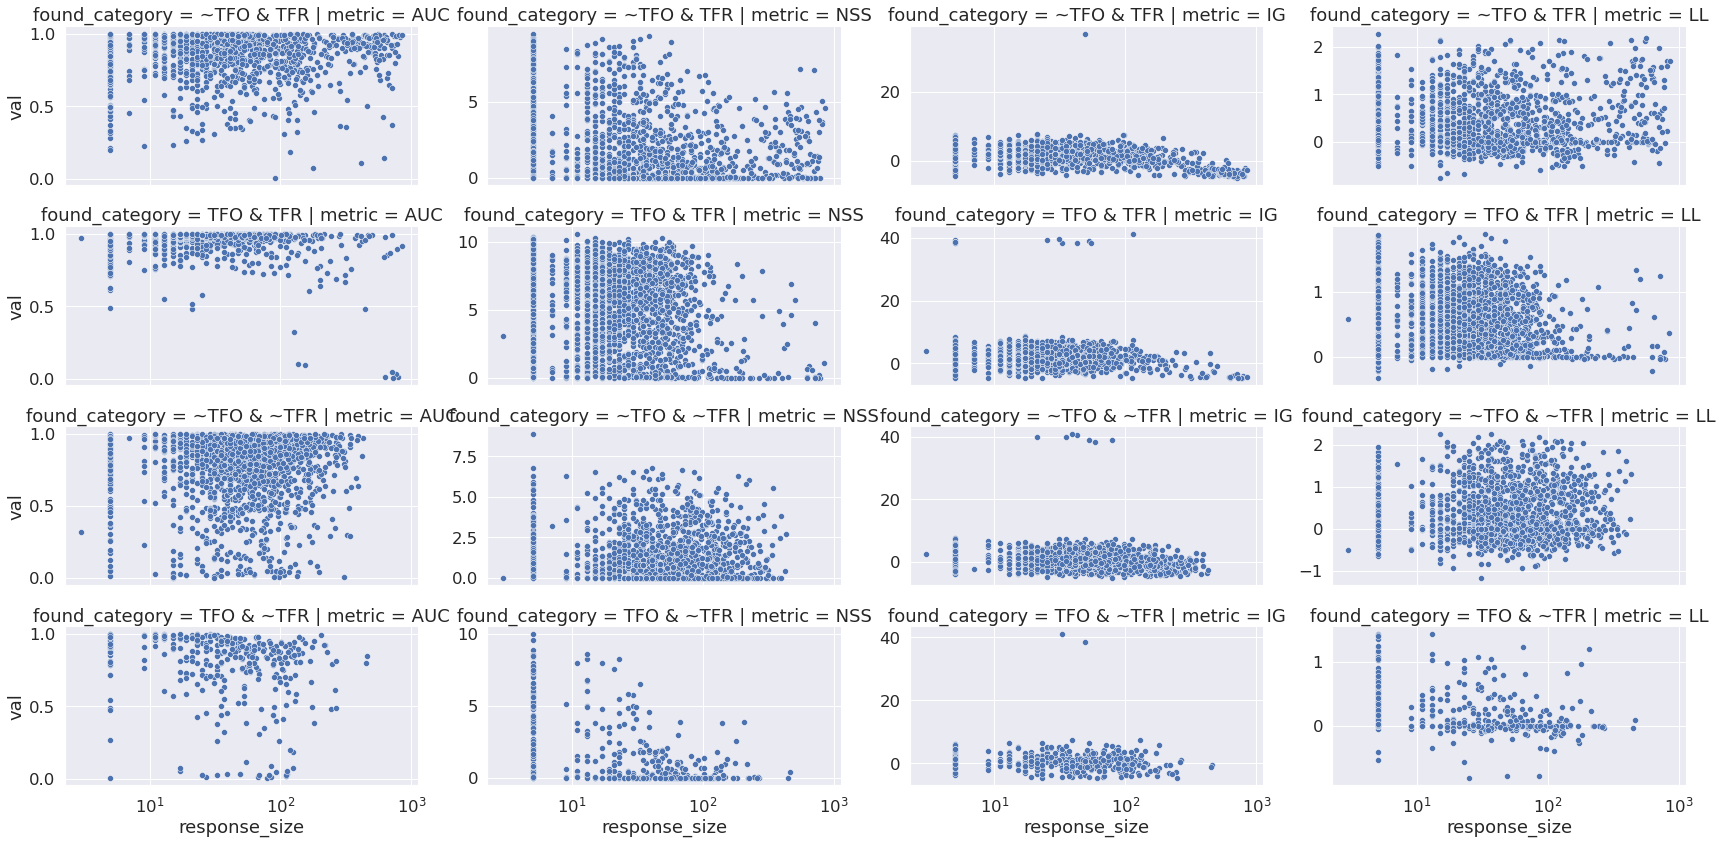

In [54]:
#
g = sns.FacetGrid(aux, row='found_category', col='metric', sharey=False, height=3, aspect=2)
g.map(sns.scatterplot, 'response_size','val').set(xscale = 'log')

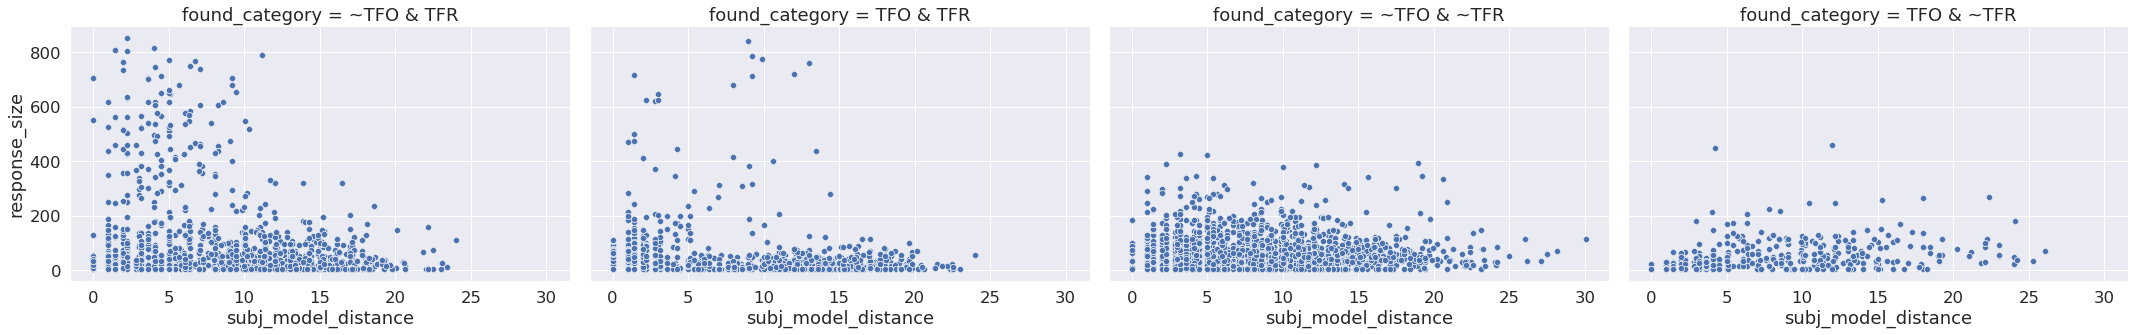

In [55]:
g = sns.FacetGrid(aux, col='found_category', sharey=True, height=5, aspect=1.5)
g.map(sns.scatterplot,'subj_model_distance','response_size')

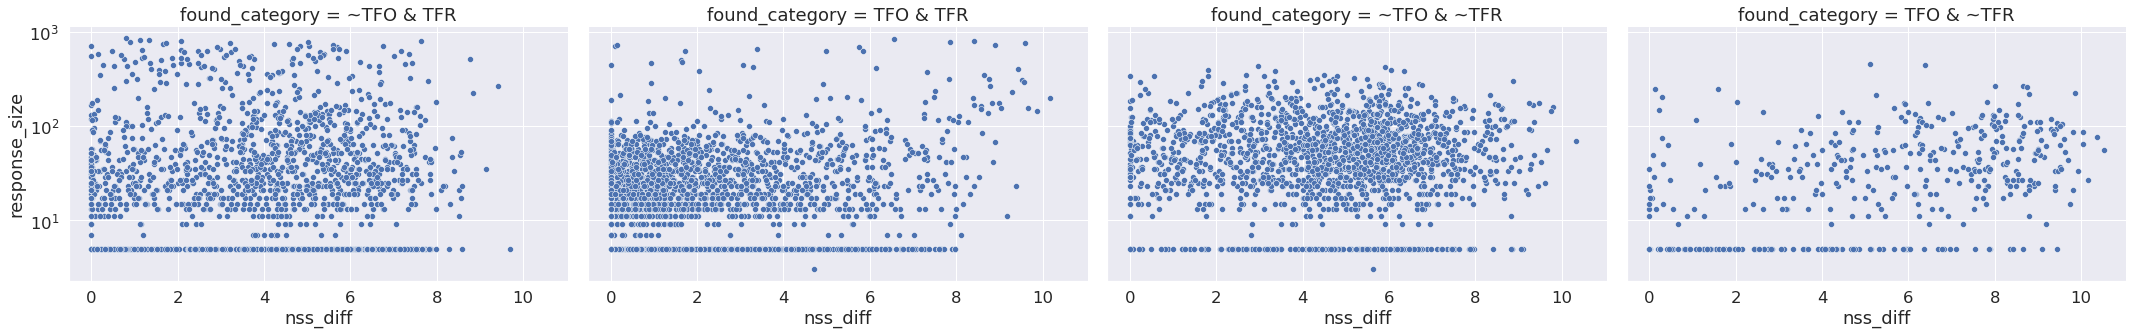

In [56]:
#
g = sns.FacetGrid(aux.query('metric=="NSS"'), col='found_category', height=5, aspect=1.5)
g.map(sns.scatterplot, 'nss_diff','response_size').set(yscale = 'log')

### Tiempo

In [74]:
sdf = sdf.merge(df_all_full[['subj','img','found_category']].drop_duplicates(),on=['subj','img'], how='outer')

<AxesSubplot:>

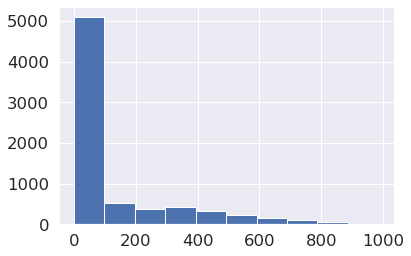

In [82]:
sdf.query('fix_order=="r"').distance_to_target.hist()

## Desagregando trials

Tengo que separar en nuevas dos categorias, vio el trial online y siguió

In [ ]:
df_all[df_all.nsacc.isin(['responses', 'last'])]

# Debug

Hay algo raro en como estan quedando los mapas guardados en cada paso intermedio, algunos ejemplos medios raros:
- 1, grayscale_1_housebeautiful
- d

Parece que si miras los últimos da algo con un poco de sentido pero despues no, parece que hay algun efecto extraño en los mapas, no cambian mucho o se vuelven constantes, o tienen las esquinas en negro

In [46]:
df_all.columns

Index(['subj', 'img', 'metric', 'nsacc', 'subj_model_distance', 'nss_subj',
       'nss_model', 'map_min', 'map_max', 'map_mean', 'map_std',
       'max_fixations', 'scanpath_length', 'target_found',
       'target_found_response', 'response_size', 'distance_to_target',
       'distance_to_last_fix', 'delta_time_response', 'response_x',
       'response_y', 'n_fix', 'val', 'mean_response', 'mean_no_response',
       'mean_last_two', 'found_category'],
      dtype='object')

In [134]:
def plot_all_fixation_maps(fixation_maps, img_name, results_path):
    # Plot all fixation maps
    n_fixs = len(fixation_maps)
    n_rows = int(np.ceil(n_fixs/3))
    fig, axes = plt.subplots(n_rows, 3, figsize=(20, 5*n_rows))
    for i,  fix_map in enumerate(fixation_maps):
        row = int(i/3)
        col = i%3
        ax = axes[row, col]
        ax.imshow(fix_map, cmap='jet')
        ax.set_title(f'fix {i}')
        ax.axis('off')
    #fig.savefig(os.path.join(results_path, f'{img_name}_fixation_maps.png'))
    plt.show()

# Miremos algunos mapas
# tmp = tl.load_fixation_maps(1, 'grayscale_1_housebeautiful.jpg',results_path)
# tmp = tl.load_fixation_maps(44, 'grayscale_1_housebeautiful.jpg',results_path)
tmp = tl.load_fixation_maps(10, 'grayscale_98_oliva.jpg',results_path)
plot_all_fixation_maps(tmp, 'grayscale_98_oliva.jpg', results_path)

AttributeError: module 'mytools' has no attribute 'load_fixation_maps'